In [1]:
# utilities
import numpy as np
import pandas as pd
from datetime import datetime

#pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#plotting
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objs as go
import seaborn as sns
from scipy.sparse import csr_matrix
plt.style.use('ggplot')
%matplotlib inline
sns.set()

#models
from surprise import KNNWithMeans
from surprise import SVDpp
from surprise import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader

#MATRIX
import scipy as sp
import os
from scipy import sparse
from scipy.sparse import csr_matrix


In [2]:
train = pd.read_csv('C:/Users/siyam/MovieData/train.csv')
test = pd.read_csv('C:/Users/siyam/MovieData/test.csv')
scores = pd.read_csv('C:/Users/siyam/MovieData/genome_scores.csv')
tags = pd.read_csv('C:/Users/siyam/MovieData/genome_tags.csv')
imbd = pd.read_csv('C:/Users/siyam/MovieData/imdb_data.csv')
links = pd.read_csv('C:/Users/siyam/MovieData/links.csv')
movies = pd.read_csv('C:/Users/siyam/MovieData/movies.csv')
sample = pd.read_csv('C:/Users/siyam/MovieData/sample_submission.csv')

In [3]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [119]:
train = train[:5000]

In [120]:
train.describe()['rating']

count    5000.000000
mean        3.528200
std         1.076957
min         0.500000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

In [121]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(train.isnull().any()))

No of Nan values in our dataframe :  0


In [122]:
dup_bool = train.duplicated(['movieId','userId','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [123]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",train.shape[0])
print("Total No of Users   :", len(np.unique(train.userId)))
print("Total No of movies  :", len(np.unique(train.movieId)))

Total data 
--------------------------------------------------

Total no of ratings : 5000
Total No of Users   : 4727
Total No of movies  : 2420


In [124]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test.shape[0])
print("Total No of Users   :", len(np.unique(test.userId)))
print("Total No of movies  :", len(np.unique(test.movieId)))

Test data 
--------------------------------------------------

Total no of ratings : 5000019
Total No of Users   : 162350
Total No of movies  : 39643


In [4]:
train_sparse_matrix = sparse.csr_matrix((train.rating.values, (train.userId.values,
                                               train.movieId.values)),)
    
print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
print('Saving it into disk for further usage..')
# save it into disk
sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
print('Done..\n')


Done. It's shape is : (user, movie) :  (162542, 209172)
Saving it into disk for further usage..
Done..



In [5]:
train_sparse_matrix

<162542x209172 sparse matrix of type '<class 'numpy.float64'>'
	with 10000038 stored elements in Compressed Sparse Row format>

In [6]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.97058746194108 % 


In [7]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [8]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5333951730983424}

In [9]:
train_averages['userId'] = get_average_ratings(train_sparse_matrix, of_users=True)
#print('\nAverage rating of user 15 :',train_averages['userId'][200])

In [10]:
train_averages['movieId'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n Average rating of movie 15 :',train_averages['movieId'][15])


 Average rating of movie 15 : 2.7363636363636363


In [11]:
total_users = len(np.unique(train.userId))
users_train = len(train_averages['userId'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 162541

Number of Users in Train data : 162541

No of Users that didn't appear in train data: 0(0.0 %) 
 


In [11]:
total_movies = len(np.unique(train.movieId))
movies_train = len(train_averages['movieId'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 48213

Number of Users in Train data : 48213

No of Movies that didn't appear in train data: 0(0.0 %) 
 


In [12]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:00:18.969784  ]
computing done for 40 users [  time elapsed : 0:00:37.832242  ]
computing done for 60 users [  time elapsed : 0:00:56.653601  ]
computing done for 80 users [  time elapsed : 0:01:16.025995  ]
computing done for 100 users [  time elapsed : 0:01:35.074083  ]
Creating Sparse matrix from the computed similarities


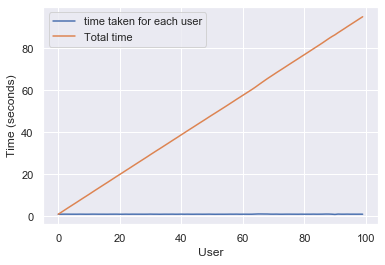

In [13]:
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)

In [14]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
truncs_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
trunc_svd = truncs_svd.fit_transform(train_sparse_matrix)

print(datetime.now()-start)

0:04:39.156381


In [15]:
expl_var = np.cumsum(truncs_svd.explained_variance_ratio_)

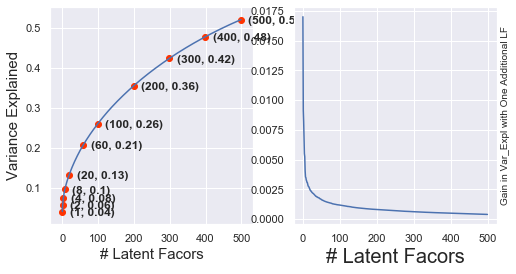

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [15]:
# Let's project our Original U_M matrix into into 500 Dimensional space...
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(truncs_svd.components_.T)
print(datetime.now()- start)

0:00:07.618738


In [16]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [17]:
trunc_sparse_matrix.shape

(162542, 500)

Computing top 50 similarities for each user..
computing done for 10 users [  time elapsed : 0:01:01.042484  ]
computing done for 20 users [  time elapsed : 0:01:59.532567  ]
computing done for 30 users [  time elapsed : 0:02:56.739626  ]
computing done for 40 users [  time elapsed : 0:03:56.060659  ]
computing done for 50 users [  time elapsed : 0:04:57.842726  ]
Creating Sparse matrix from the computed similarities


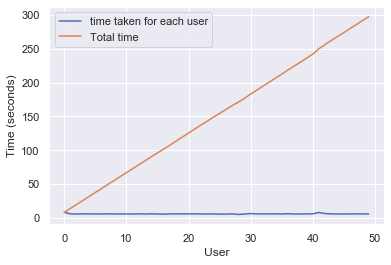

--------------------------------------------------
time: 0:05:38.520138


In [18]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)
print("-"*50)
print("time:",datetime.now()-start)

In [22]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse) 
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (209172, 209172)  dimensional matrix
0:08:52.111389


In [23]:
m_m_sim_sparse.shape

(209172, 209172)

In [ ]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])